In [1]:
import pandas as pd
import matplotlib.ticker as tick
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.patches as pplt
import matplotlib.cm as cm
from matplotlib import lines
import datetime
import plotly.graph_objects as go
from matplotlib import rcParams as rcp

# Setting variables

In [2]:
gene_name1 = input('Gene name 1: ')
gene_name2 = input('Gene name 2 (if wanted, else press enter): ')
date = str(datetime.date.today())

# joint file of gene
df1 = pd.read_csv(r'joint_files_out/' + gene_name1.lower() + '_joint_out.csv')
dfs = [df1]
gene_names = [gene_name1]
if gene_name2 != '':
    df2 = pd.read_csv(r'joint_files_out/' + gene_name2.lower() + '_joint_out.csv')
    dfs.append(df2)
    gene_names.append(gene_name2)

# SIFT_VEP and PolyPhen_VEP combined str and float values -> create one column for each
for df in dfs:
    df[['SIFT_VEP_str', 'SIFT_VEP_num']] = df['SIFT_VEP'].str.split('(', expand = True)
    df['SIFT_VEP_num'] = df['SIFT_VEP_num'].str.strip(')').astype(float)
    df[['PolyPhen_VEP_str', 'PolyPhen_VEP_num']] = df['PolyPhen_VEP'].str.split('(', expand = True)
    df['PolyPhen_VEP_num'] = df['PolyPhen_VEP_num'].str.strip(')').astype(float)
    df['Consequence_VEP'] = df['Consequence_VEP'].str.replace('_', ' ')
    df['Consequence_VEP'] = df['Consequence_VEP'].str.replace(',', ', ')

Gene name 1: brca1
Gene name 2 (if wanted, else press enter): brca2


C:\Users\alexa\anaconda\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (43,47) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
# coding sequences as df
coding_df1 = df1.loc[df1['Protein_position'].notnull()].copy()
coding_dfs = [coding_df1]
# unique positions (+ introns)
all_pos1 = list(df1['POS'].unique())
all_pos = [all_pos1]

if gene_name2 != '':
    coding_df2 = df2.loc[df2['Protein_position'].notnull()].copy()
    coding_dfs.append(coding_df2)
    all_pos2 = list(df2['POS'].unique())
    all_pos.append(all_pos2)

revs = []
for df, cod in zip(dfs, coding_dfs):
    if df.iloc[0]['Strand'] == '+':
        cod.sort_values(by = ['POS'], ascending = True, ignore_index = True, inplace = True)
        revs.append(False)
    elif df.iloc[0]['Strand'] == '-':
        cod.sort_values(by = ['POS'], ascending = False, ignore_index = True, inplace = True)
        revs.append(True)
    cod['Protein_position'] = cod['Protein_position'].astype(int)
    cod['POS'] = cod['POS'].astype(int)

# unique coding positions list and length
codpos1 = list(coding_df1['POS'].unique())
codpos = [codpos1]
cod1_len = len(codpos1)
if gene_name2 != '':
    codpos2 = list(coding_df2['POS'].unique())
    codpos.append(codpos2)
    cod2_len = len(codpos2)-1

for pos,cpos,r in zip(all_pos, codpos, revs):
    pos.sort(reverse = r)
    cpos.sort(reverse = r)

# aa length per gene
aa1_len = len(list(coding_df1['Protein_position'].unique()))
aa2_len = len(list(coding_df2['Protein_position'].unique()))

In [4]:
# search for exon start/stop
tuple_exons = []
for df, cpos in zip(dfs, codpos):
    exons_beg = []
    exons_end = []
    tuple_exons_in = []
    if df.iloc[0]['Strand'] == '+':
        for el in cpos:
            if el-1 not in cpos:
                exons_beg.append(el)
            elif el+1 not in cpos:
                exons_end.append(el)
            else:
                continue
    elif df.iloc[0]['Strand'] == '-':
        for el in cpos:
            if el+1 not in cpos:
                exons_beg.append(el)
            elif el-1 not in cpos:
                exons_end.append(el)
            else:
                continue
    else:
        pass
    for x, y in zip(exons_beg, exons_end):
        tuple_exons_in.append((x,y))
    tuple_exons.append(tuple_exons_in)

tuple_exons1 = tuple_exons[0]
if len(tuple_exons) > 1:
    tuple_exons2 = tuple_exons[1]

In [5]:
# exon numbers position
txt_pos1 = []
for x in range(len(tuple_exons1)):
    if (int(x)+1)%2 != 0:
        txt_pos1.append(-0.4)
    elif (int(x)+1)%2 == 0:
        txt_pos1.append(0.4)
if gene_name2 != '':
    txt_pos2 = []
    for x in range(len(tuple_exons2)):
        if (int(x)+1)%2 != 0:
            txt_pos2.append(-0.4)
        elif (int(x)+1)%2 == 0:
            txt_pos2.append(0.4)
else:
    pass

# Overview of gene

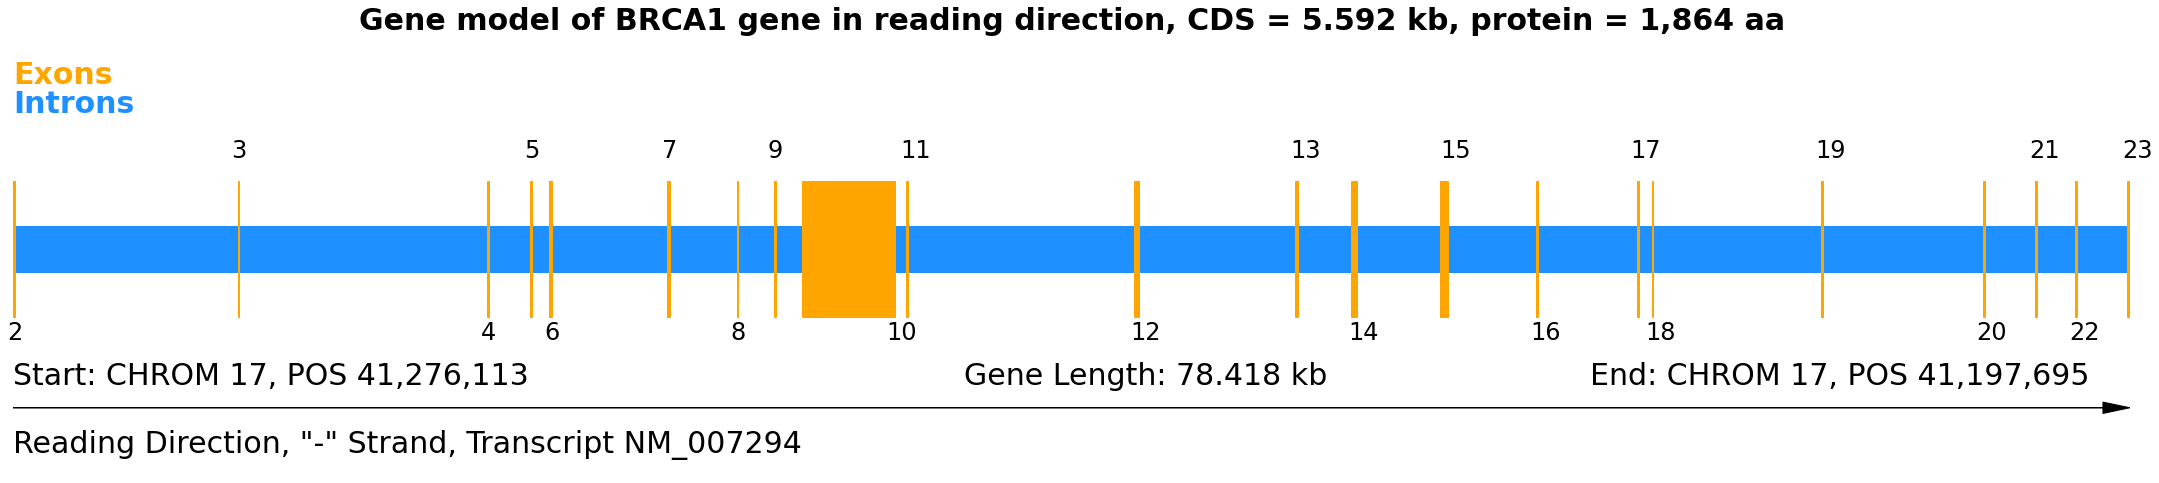

In [42]:
# exons and introns for 1st gene
fig,ax = plt.subplots(figsize=(30, 7))
plt.ylim([-1, 1])
plt.axis('off')
fig.suptitle('Gene model of ' + gene_name1.upper() + ' gene in reading direction, CDS = ' + str(cod1_len/1000) +
             ' kb, protein = ' + str('{:,.0f}'.format(aa1_len)) + ' aa', fontsize = 30, fontweight = 'bold')
plt.xlim(tuple_exons1[0][0], tuple_exons1[-1][1])
if df1.iloc[0]['Strand'] == '+':
    ax.add_patch(pplt.Rectangle((tuple_exons1[0][0], -.1), tuple_exons1[-1][1], .2, fc = 'dodgerblue', 
                                ec = 'dodgerblue', alpha = 1, label = 'Introns'))
    ax.arrow(tuple_exons1[0][0], -0.7, abs(tuple_exons1[-1][1]-tuple_exons1[0][0])-1000, 0, head_width = 0.05,
             head_length = 1000, fc = 'k', ec = 'k')
    for tup,l in zip(tuple_exons1, range(len(tuple_exons1))):
        ax.add_patch(pplt.Rectangle((int(tup[0]), -.3), abs(int(tup[0])-int(tup[1])), .6, fc = 'orange', 
                                    ec = 'orange', alpha = 1))
        plt.text(int(tup[0]-300), txt_pos1[int(l)], str((int(l)+2)), size = 24)
    plt.text(tuple_exons1[-1][1]-20000, -0.6, 'End: CHROM ' + str(df1.iloc[0]['CHROM']) + ', POS ' + 
         str('{:,.0f}'.format(tuple_exons1[-1][1])), size = 30)
    plt.text((tuple_exons1[0][0] + abs(tuple_exons1[-1][1]-tuple_exons1[0][0])/2)-4000, -0.6, 
             'Gene Length: ' + str(abs(tuple_exons1[-1][1]-tuple_exons1[0][0])/1000) + ' kb', size = 30)
elif df1.iloc[0]['Strand'] == '-':
    ax.add_patch(pplt.Rectangle((tuple_exons1[-1][1], -.1), tuple_exons1[0][0], .2, fc = 'dodgerblue', 
                                ec = 'dodgerblue', alpha = 1, label = 'Introns'))
    ax.arrow(tuple_exons1[0][0], -0.7, -abs(tuple_exons1[-1][1]-tuple_exons1[0][0])+1000, 0, head_width = 0.05,
             head_length = 1000, fc = 'k', ec = 'k')
    for tup,l in zip(tuple_exons1, range(len(tuple_exons1))):
        ax.add_patch(pplt.Rectangle((int(tup[1]), -.3), abs(int(tup[0])-int(tup[1])), .6, fc = 'orange', 
                                    ec = 'orange', alpha = 1))
        plt.text(int(tup[1]+300), txt_pos1[int(l)], str((int(l)+2)), size = 24)
    plt.text(tuple_exons1[-1][1]+20000, -0.6, 'End: CHROM ' + str(df1.iloc[0]['CHROM']) + ', POS ' + 
         str('{:,.0f}'.format(tuple_exons1[-1][1])), size = 30)
    plt.text((tuple_exons1[0][0] - abs(tuple_exons1[-1][1]-tuple_exons1[0][0])/2)+4000, -0.6, 
             'Gene Length: ' + str(abs(tuple_exons1[-1][1]-tuple_exons1[0][0])/1000) + ' kb', size = 30)

plt.text(tuple_exons1[0][0], 0.73, 'Exons', c = 'orange', size = 30, fontweight = 'bold')
plt.text(tuple_exons1[0][0], 0.6, 'Introns', c = 'dodgerblue', size = 30, fontweight = 'bold')

plt.text(tuple_exons1[0][0], -0.9, ('Reading Direction, "' + str(df1.iloc[0]['Strand']) + '" Strand'+ 
                                    ', Transcript ' + str(df1.iloc[0]['Ref_Trans_VEP'])), size = 30)

plt.text(tuple_exons1[0][0], -0.6, 'Start: CHROM ' + str(df1.iloc[0]['CHROM']) + ', POS ' + 
         str('{:,.0f}'.format(tuple_exons1[0][0])), size = 30)


plt.gcf().subplots_adjust(bottom = 0.05, top = 0.95, left = 0.01, right = 0.99);

plt.savefig(r'figures/' + date + '_' + gene_name1.lower() + '_exins_ov.pdf')
plt.savefig(r'figures/' + date + '_' + gene_name1.lower() + '_exins_ov.jpg')

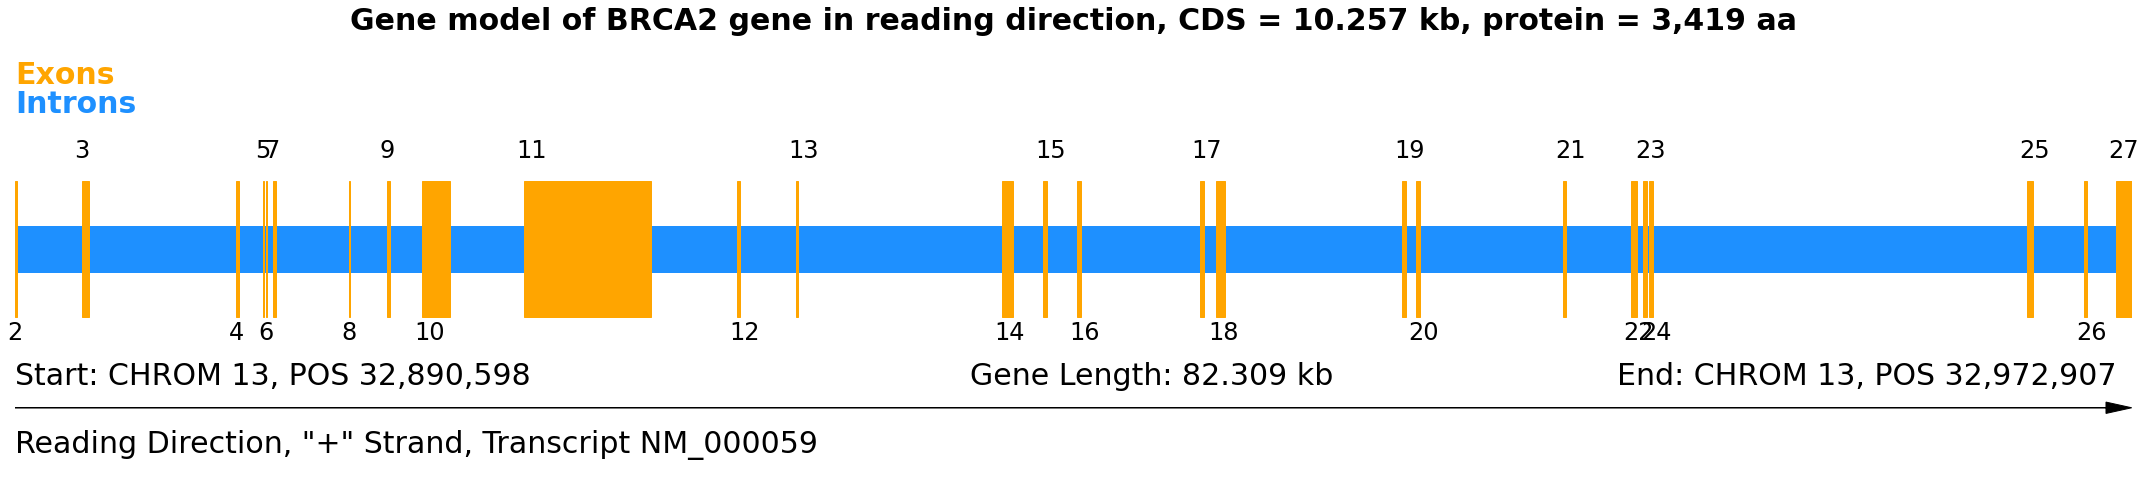

In [40]:
# exons and introns for 2nd gene
if gene_name2 != '':
    fig,ax = plt.subplots(figsize=(30, 7))
    plt.ylim([-1, 1])
    plt.axis('off')
    fig.suptitle('Gene model of ' + gene_name2.upper() + ' gene in reading direction, CDS = ' + 
                 str(cod2_len/1000) + ' kb, protein = ' + str('{:,.0f}'.format(aa2_len)) + ' aa', 
                 fontsize = 30, fontweight = 'bold')
    plt.xlim(tuple_exons2[0][0], tuple_exons2[-1][1])
    if df2.iloc[0]['Strand'] == '+':
        ax.add_patch(pplt.Rectangle((tuple_exons2[0][0], -.1), tuple_exons2[-1][1], .2, fc = 'dodgerblue', 
                                    ec = 'dodgerblue', alpha = 1, label = 'Introns'))
        ax.arrow(tuple_exons2[0][0], -0.7, abs(tuple_exons2[-1][1]-tuple_exons2[0][0])-1000, 0, 
                 head_width = 0.05, head_length = 1000, fc = 'k', ec = 'k')
        for tup,l in zip(tuple_exons2, range(len(tuple_exons2))):
            ax.add_patch(pplt.Rectangle((int(tup[0]), -.3), abs(int(tup[0])-int(tup[1])), .6, fc = 'orange', 
                                        ec = 'orange', alpha = 1))
            plt.text(int(tup[0]-300), txt_pos2[int(l)], str((int(l)+2)), size = 24)
        plt.text(tuple_exons2[-1][1]-20000, -0.6, 'End: CHROM ' + str(df2.iloc[0]['CHROM']) + ', POS ' + 
             str('{:,.0f}'.format(tuple_exons2[-1][1])), size = 30)
        plt.text((tuple_exons2[0][0] + abs(tuple_exons2[-1][1]-tuple_exons2[0][0])/2)-4000, -0.6, 
                 'Gene Length: ' + str(abs(tuple_exons2[-1][1]-tuple_exons2[0][0])/1000) + ' kb', size = 30)
    elif df2.iloc[0]['Strand'] == '-':
        ax.add_patch(pplt.Rectangle((tuple_exons2[-1][1], -.1), tuple_exons2[0][0], .2, fc = 'dodgerblue', 
                                    ec = 'dodgerblue', alpha = 1, label = 'Introns'))
        ax.arrow(tuple_exons2[0][0], -0.7, -abs(tuple_exons2[-1][1]-tuple_exons2[0][0])+1000, 0, 
                 head_width = 0.05, head_length = 1000, fc = 'k', ec = 'k')
        for tup,l in zip(tuple_exons2, range(len(tuple_exons2))):
            ax.add_patch(pplt.Rectangle((int(tup[1]), -.3), abs(int(tup[0])-int(tup[1])), .6, fc = 'orange', 
                                        ec = 'orange', alpha = 1))
            plt.text(int(tup[1]+300), txt_pos2[int(l)], str((int(l)+2)), size = 24)
        plt.text(tuple_exons2[-1][1]+20000, -0.6, 'End: CHROM ' + str(df2.iloc[0]['CHROM']) + ', POS ' + 
             str('{:,.0f}'.format(tuple_exons2[-1][1])), size = 30)
        plt.text((tuple_exons2[0][0] - abs(tuple_exons2[-1][1]-tuple_exons2[0][0])/2)+4000, -0.6, 
                 'Gene Length: ' + str(abs(tuple_exons2[-1][1]-tuple_exons2[0][0])/1000) + ' kb', size = 30)

    plt.text(tuple_exons2[0][0], 0.73, 'Exons', c = 'orange', size = 30, fontweight = 'bold')
    plt.text(tuple_exons2[0][0], 0.6, 'Introns', c = 'dodgerblue', size = 30, fontweight = 'bold')

    plt.text(tuple_exons2[0][0], -0.9, ('Reading Direction, "' + str(df2.iloc[0]['Strand']) + '" Strand' + 
                                        ', Transcript ' + str(df2.iloc[0]['Ref_Trans_VEP'])), size = 30)

    plt.text(tuple_exons2[0][0], -0.6, 'Start: CHROM ' + str(df2.iloc[0]['CHROM']) + ', POS ' + 
             str('{:,.0f}'.format(tuple_exons2[0][0])), size = 30)


    plt.gcf().subplots_adjust(bottom = 0.05, top = 0.95, left = 0.01, right = 0.99);

    plt.savefig(r'figures/' + date + '_' + gene_name2.lower() + '_exins_ov.pdf')
    plt.savefig(r'figures/' + date + '_' + gene_name2.lower() + '_exins_ov.jpg')
else:
    pass

# Overview of annotations

In [8]:
# for pie chart with origin of variants, plus info of exon/intron
# 1st gene
sizes = []
labels = []
cols = []
sizes_sg = []
labels_sg = []
cols_sg = []

for df in dfs:
    sizes.append([len(df[df['AC_gnomAD'].notnull() & df['ClinVar_gnomAD'].notnull()]), 
                  len(df[df['AC_gnomAD'].notnull() & df['ClinVar_gnomAD'].isnull()]), 
                  len(df[df['Cancer_Type_cBP'].notnull()]),
                  len(df[df['Trans_Version_Flossies'].notnull()]), 
                  len(df[df['NCT_SAMPLE_NAME'].notnull()]), 
                 ])
    labels.append(['GnomAD (+ ClinVar)',
                    'GnomAD (w/o ClinVar)',
                    'cBioPortal',
                    'Flossies',
                    'MASTER/NCT project',
                  ])
    cols.append(['red', 'orange', 'green', 'dodgerblue', 'magenta'])
    sizes_sg.append([len(df[df['AC_gnomAD'].notnull() & df['ClinVar_gnomAD'].notnull() & df['EXON'].notnull()]), 
            len(df[df['AC_gnomAD'].notnull() & df['ClinVar_gnomAD'].notnull() & df['EXON'].isnull()]), 
            len(df[df['AC_gnomAD'].notnull() & df['ClinVar_gnomAD'].isnull() & df['EXON'].notnull()]), 
            len(df[df['AC_gnomAD'].notnull() & df['ClinVar_gnomAD'].isnull() & df['EXON'].isnull()]), 
            len(df[df['Cancer_Type_cBP'].notnull() & df['EXON'].notnull()]), 
            len(df[df['Cancer_Type_cBP'].notnull() & df['EXON'].isnull()]), 
            len(df[df['Trans_Version_Flossies'].notnull() & df['EXON'].notnull()]), 
            len(df[df['Trans_Version_Flossies'].notnull() & df['EXON'].isnull()]), 
            len(df[df['NCT_SAMPLE_NAME'].notnull() & df['EXON'].notnull()]),
            len(df[df['NCT_SAMPLE_NAME'].notnull() & df['EXON'].isnull()]),
           ])
    labels_sg.append(['E', 'I', 'E', 'I', 'E', 'I', 'E', 'I', 'E', 'I'])
    cols_sg.append(['lightcoral', 'lightsalmon', 'gold', 'bisque', 'chartreuse', 'palegreen', 
          'deepskyblue', 'lightskyblue', 'violet', 'lightpink'])

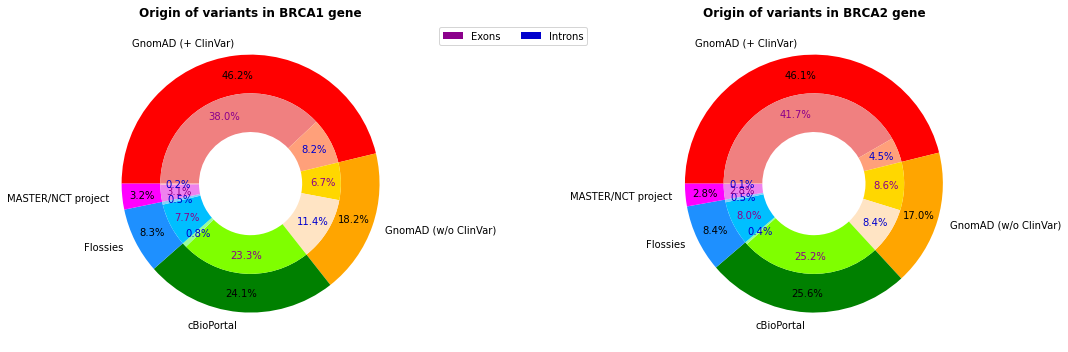

In [9]:
fig = plt.subplots(figsize=(15, 5))
# pie plot in coding sequence + 75 bp padding for gene 1, exon vs. intron
rcp.update({'hatch.color':'gray'})
if gene_name2 != '':
    ax1 = plt.subplot(1,2,1)
else:
    ax1 = plt.subplot(1,1,1)
ax1.set_title('Origin of variants in ' + gene_name1.upper() + ' gene', fontsize = 12, fontweight = 'bold')
ax1.pie(sizes[0], labels = labels[0], autopct = '%1.1f%%', startangle = 180, pctdistance = 0.85, 
        colors = cols[0], counterclock = False, radius = 1, wedgeprops = dict(width = 0.3), 
        textprops = {'fontsize':10})
piech1 = ax1.pie(sizes_sg[0], autopct = '%1.1f%%', startangle = 180, pctdistance = 0.8, 
            colors = cols_sg[0], textprops = {'fontsize':10},
            counterclock = False, radius = 0.7, wedgeprops = dict(width = 0.3))
for i in range(len(piech1[0])):
    if (i+1)%2 == 0:
        piech1[2][i].set_color('mediumblue')
    if (i+1)%2 != 0:
        piech1[2][i].set_color('darkmagenta');
ax1.legend(handles = [pplt.Patch(label = 'Exons', facecolor = 'darkmagenta'), 
                      pplt.Patch(label = 'Introns', facecolor = 'mediumblue')], 
            bbox_to_anchor = (1.56, 1), ncol = 2)

# pie plot in coding sequence + 75 bp padding for gene 2, exon vs. intron
if gene_name2 != '':
    ax2 = plt.subplot(1,2,2)
    ax2.set_title('Origin of variants in ' + gene_name2.upper() + ' gene', fontsize = 12, fontweight = 'bold')
    ax2.pie(sizes[1], labels = labels[1], autopct = '%1.1f%%', startangle = 180, pctdistance = 0.85, 
            colors = cols[1], counterclock = False, radius = 1, wedgeprops = dict(width = 0.3), 
            textprops = {'fontsize':10})
    piech2 = ax2.pie(sizes_sg[1], autopct = '%1.1f%%', startangle = 180, pctdistance = 0.8, 
                colors = cols_sg[1], textprops = {'fontsize':10},
                counterclock = False, radius = 0.7, wedgeprops = dict(width = 0.3))
    for i in range(len(piech2[0])):
        if (i+1)%2 == 0:
            piech2[2][i].set_color('mediumblue')
        if (i+1)%2 != 0:
            piech2[2][i].set_color('darkmagenta');
    plt.tight_layout()
    plt.savefig(r'figures/' + date + '_' + gene_name1.lower() + '_' + gene_name2.lower() + '_orig_vars.pdf')
    plt.savefig(r'figures/' + date + '_' + gene_name1.lower() + '_' + gene_name2.lower() + '_orig_vars.jpg')
else:
    plt.tight_layout()
    plt.savefig(r'figures/' + date + '_' + gene_name1.lower() + '_orig_vars.pdf')
    plt.savefig(r'figures/' + date + '_' + gene_name1.lower() + '_orig_vars.jpg')

# Overview of ClinVar/VEP impact

In [10]:
#synthetic variants (expected) vs. variants in databases (observed)
all_vars = []
syn_vars_in = []
syn_vars_ex = []
db_vars_in = []
db_vars_ex = []
# value counts as df for all groups
for df in dfs:
    all_vars.append(pd.DataFrame(df['Consequence_VEP'].value_counts()))
    syn_vars_in.append(pd.DataFrame(df['Consequence_VEP'][(df['Trans_Version_Syn'].notnull())&
                                             (df['INTRON'].notnull())].value_counts()))
    syn_vars_ex.append(pd.DataFrame(df['Consequence_VEP'][(df['Trans_Version_Syn'].notnull())&
                                             (df['EXON'].notnull())].value_counts()))
    db_vars_in.append(pd.DataFrame(df['Consequence_VEP'][(df['Trans_Version_Flossies'].notnull())|
                                            (df1['Cancer_Type_cBP'].notnull())|
                                            (df1['AF_gnomAD'].notnull())|
                                            (df1['NCT_SAMPLE_NAME'].notnull())&
                                            (df['INTRON'].notnull())].value_counts()))
    db_vars_ex.append(pd.DataFrame(df['Consequence_VEP'][(df['Trans_Version_Flossies'].notnull())|
                                            (df1['Cancer_Type_cBP'].notnull())|
                                            (df1['AF_gnomAD'].notnull())|
                                            (df1['NCT_SAMPLE_NAME'].notnull())&
                                            (df['INTRON'].notnull())].value_counts()))
# index as column, append right suffixes
jnt_vars = []
sufx = ['_all', '_syn_in', '_syn_ex', '_db_in', '_db_ex']
for i,el in enumerate([all_vars,syn_vars_in,syn_vars_ex,db_vars_in,db_vars_ex]):
    for data in el:
        data['index_1'] = data.index
    jnt_vars.append(el[0].merge(el[1], on = 'index_1', suffixes = [(sufx[i]+'_1'), (sufx[i]+'_2')], 
                                how = 'outer'))
# merge all together
merged_vars = jnt_vars[0].merge(jnt_vars[1], on = 'index_1', how = 'outer').merge(jnt_vars[2], on = 'index_1',
                            how = 'outer').merge(jnt_vars[3], on = 'index_1', how = 'outer').merge(jnt_vars[4],
                            on = 'index_1', how = 'outer')
inex_cols = []
for x in merged_vars['index_1']:
    if x in ['intron variant', 'splice region variant, intron variant', 'splice donor variant', 
             'splice acceptor variant']:
        inex_cols.append('dodgerblue')
    else:
        inex_cols.append('orange')

In [11]:
# variant consequences: relative values
ct_syn_all1 = merged_vars['Consequence_VEP_syn_in_1'].sum() + merged_vars['Consequence_VEP_syn_ex_1'].sum()
ct_syn_all2 = merged_vars['Consequence_VEP_syn_in_2'].sum() + merged_vars['Consequence_VEP_syn_ex_2'].sum()
ct_db_all1 = merged_vars['Consequence_VEP_db_in_1'].sum() + merged_vars['Consequence_VEP_db_ex_1'].sum()
ct_db_all2 = merged_vars['Consequence_VEP_db_in_2'].sum() + merged_vars['Consequence_VEP_db_ex_2'].sum()
SynToDb1 = ct_db_all1/ct_syn_all1
SynToDb2 = ct_db_all2/ct_syn_all2

for col1,col2 in zip(['Consequence_VEP_syn_in_1', 'Consequence_VEP_syn_ex_1'], 
                     ['Consequence_VEP_syn_in_2', 'Consequence_VEP_syn_ex_2']):
    merged_vars[(col1 + '_rel')] = merged_vars[col1]*SynToDb1
    merged_vars[(col2 + '_rel')] = merged_vars[col2]*SynToDb2

G1ToG2 = ct_syn_all1/ct_syn_all2

In [12]:
# for pathogenicity by ClinVar, all, exons, introns
path1_val = df1['ClinVar_gnomAD'][df1['ClinVar_gnomAD'].notnull()].value_counts()
path1_val_df = pd.DataFrame(path1_val)
path1_val_ex1_df = pd.DataFrame(df1['ClinVar_gnomAD'][(df1['ClinVar_gnomAD'].notnull()) &
                                      (df1['EXON'].notnull())].value_counts())
path1_val_in1_df = pd.DataFrame(df1['ClinVar_gnomAD'][(df1['ClinVar_gnomAD'].notnull()) &
                                      (df1['INTRON'].notnull())].value_counts())
# for impact by VEP
imp1 = df1['Consequence_VEP'][df1['Consequence_VEP'].notnull()].value_counts()

# for gene 2
if gene_name2 != '':
    path2_val = df2['ClinVar_gnomAD'][df2['ClinVar_gnomAD'].notnull()].value_counts()
    path2_val_df = pd.DataFrame(path2_val)
    path2_val_ex2_df = pd.DataFrame(df2['ClinVar_gnomAD'][(df2['ClinVar_gnomAD'].notnull()) &
                                          (df2['EXON'].notnull())].value_counts())
    path2_val_in2_df = pd.DataFrame(df2['ClinVar_gnomAD'][(df2['ClinVar_gnomAD'].notnull()) &
                                          (df2['INTRON'].notnull())].value_counts())
    imp2 = df2['Consequence_VEP'][df2['Consequence_VEP'].notnull()].value_counts()

In [13]:
# pathogenicity, ClinVar order
for el in [path1_val_df, path1_val_ex1_df, path1_val_in1_df, path2_val_df, path2_val_ex2_df, 
           path2_val_in2_df]:
    el['index_1'] = el.index
all_pat1_df = path1_val_df.merge(path1_val_ex1_df, on = 'index_1', suffixes = ['_all1', '_ex1']
                  ).merge(path1_val_in1_df, on = 'index_1')
all_pat1_df = all_pat1_df.rename(columns = {'ClinVar_gnomAD':'ClinVar_gnomAD_in1'})
all_pat2_df = path2_val_df.merge(path2_val_ex2_df, on = 'index_1', suffixes = ['_all2', '_ex2']
                  ).merge(path2_val_in2_df, on = 'index_1')
all_pat2_df = all_pat2_df.rename(columns = {'ClinVar_gnomAD':'ClinVar_gnomAD_in2'})
all_pat_df = all_pat1_df.merge(all_pat2_df, on = 'index_1', how = 'outer')
# --> with these stacked bar plot
clinvar_order = pd.CategoricalDtype(['Pathogenic', 'Pathogenic/Likely pathogenic', 
                                     'Likely pathogenic',
                                     'Conflicting interpretations of pathogenicity',
                                     'Likely benign', 'Benign/Likely benign', 'Benign',
                                     'Uncertain significance', 'not provided'], ordered = True)
all_pat_df['index_1'] = all_pat_df['index_1'].astype(clinvar_order)
all_pat_df = all_pat_df.sort_values('index_1')

for el in ['ClinVar_gnomAD_all2', 'ClinVar_gnomAD_ex2', 'ClinVar_gnomAD_in2']:
    all_pat_df[el+'_rel'] = all_pat_df[el]*G1ToG2

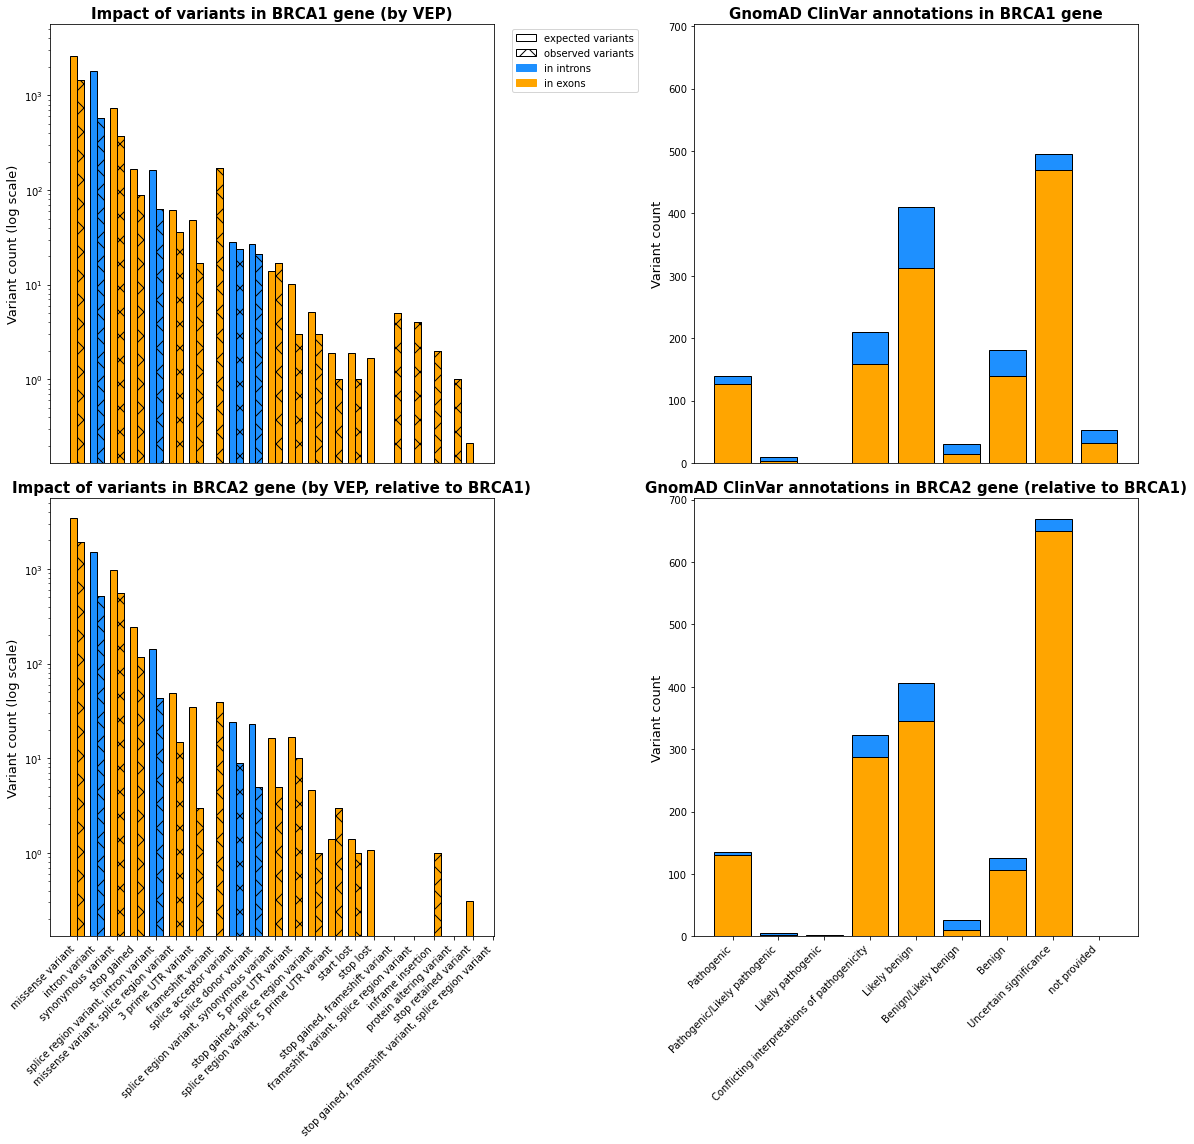

In [80]:
fig = plt.subplots(figsize=(16, 16))
ax1 = plt.subplot(2,2,1)
ax2 = plt.subplot(2,2,3, sharey = ax1, sharex = ax1)
ax3 = plt.subplot(2,2,2)
ax4 = plt.subplot(2,2,4, sharey = ax3, sharex = ax3)

or_leg = pplt.Patch(color = 'orange', label = 'in exons')
blue_leg = pplt.Patch(color = 'dodgerblue', label = 'in introns')
g1_leg = pplt.Patch(color = 'black', label = 'expected variants', fill = False)
g2_leg = pplt.Patch(color = 'black', hatch = 'x', label = 'observed variants', fill = False)

# impact of variants gene 1 (expected vs. observed)
ar1 = np.arange(len(merged_vars['index_1']))
wid1 = 0.35
ax1.set_xticks(ar1)
#ax1.set_xticklabels(merged_vars['index_1'], rotation = 45, ha = 'right')
ax1.set_title('Impact of variants in ' + gene_name1.upper() + 
              ' gene (by VEP)', fontsize = 15, fontweight = 'bold')
bar1 = ax1.bar(ar1-wid1/2, merged_vars['Consequence_VEP_syn_in_1_rel'], color = inex_cols, width = wid1, 
               label = gene_name1.upper(), edgecolor = 'black')
bar2 = ax1.bar(ar1-wid1/2, merged_vars['Consequence_VEP_syn_ex_1_rel'], color = inex_cols, width = wid1, 
               label = gene_name1.upper(), edgecolor = 'black')
bar3 = ax1.bar(ar1+wid1/2, merged_vars['Consequence_VEP_db_in_1'], color = inex_cols, width = wid1, 
               label = gene_name1.upper(), hatch = 'x', edgecolor = 'black')
bar4 = ax1.bar(ar1+wid1/2, merged_vars['Consequence_VEP_db_ex_1'], color = inex_cols, width = wid1, 
               label = gene_name1.upper(), hatch = 'x', edgecolor = 'black')
ax1.get_xaxis().set_visible(False)
ax1.set_ylabel('Variant count (log scale)', fontsize = 13)
ax1.set_yscale('log')

# impact of variants gene 2 (expected vs. observed)
ar2 = np.arange(len(merged_vars['index_1']))
wid2 = 0.35
ax2.set_xticks(ar2)
ax2.set_xticklabels(merged_vars['index_1'], rotation = 45, ha = 'right')
ax2.set_title('Impact of variants in ' + gene_name2.upper() + 
              ' gene (by VEP, relative to ' + gene_name1.upper() + ')', fontsize = 15, fontweight = 'bold')
bar21 = ax2.bar(ar2-wid2/2, merged_vars['Consequence_VEP_syn_in_2_rel'], color = inex_cols, width = wid2, 
               label = gene_name2.upper(), edgecolor = 'black')
bar22 = ax2.bar(ar2-wid2/2, merged_vars['Consequence_VEP_syn_ex_2_rel'], color = inex_cols, width = wid2, 
               label = gene_name2.upper(), edgecolor = 'black')
bar23 = ax2.bar(ar2+wid2/2, merged_vars['Consequence_VEP_db_in_2'], color = inex_cols, width = wid2, 
               label = gene_name2.upper(), hatch = 'x', edgecolor = 'black')
bar24 = ax2.bar(ar2+wid2/2, merged_vars['Consequence_VEP_db_ex_2'], color = inex_cols, width = wid2, 
               label = gene_name2.upper(), hatch = 'x', edgecolor = 'black')
ax2.set_ylabel('Variant count (log scale)', fontsize = 13)
ax2.set_yscale('log')
plt.tight_layout()
#'''
ar3 = np.arange(len(all_pat_df['index_1']))
#wid3 = 0.35
ax3.set_xticks(ar3)
ax3.set_xticklabels(all_pat_df['index_1'], rotation = 45, ha = 'right')
ax3.set_title(('GnomAD ClinVar annotations in ' + gene_name1.upper() 
               + ' gene'), fontsize = 15, fontweight = 'bold')
ax3.bar(ar3, all_pat_df['ClinVar_gnomAD_ex1'],
       label = 'exons', color = 'orange', edgecolor = 'black')
ax3.bar(ar3, all_pat_df['ClinVar_gnomAD_in1'],
        label = 'introns', bottom = all_pat_df['ClinVar_gnomAD_ex1'], 
        color = 'dodgerblue', edgecolor = 'black')
ax3.get_xaxis().set_visible(False)
#ax3.set_yscale('log')
ax3.set_ylabel('Variant count', fontsize = 13)
#'''
#'''
ar4 = np.arange(len(all_pat_df['index_1']))
ax4.set_xticks(ar3)
ax4.set_xticklabels(all_pat_df['index_1'], rotation = 45, ha = 'right')
ax4.set_title(('GnomAD ClinVar annotations in ' + gene_name2.upper() 
               + ' gene (relative to ' + gene_name1.upper() + ')'), fontsize = 15, fontweight = 'bold')
ax4.bar(ar4, all_pat_df['ClinVar_gnomAD_ex2_rel'],
       label = 'exons', color = 'orange', edgecolor = 'black')
ax4.bar(ar4, all_pat_df['ClinVar_gnomAD_in2_rel'],
        label = 'introns', bottom = all_pat_df['ClinVar_gnomAD_ex2_rel'], 
        color = 'dodgerblue', edgecolor = 'black')
#ax3.get_yaxis().set_visible(False)
#ax4.set_yscale('log')
ax4.set_ylabel('Variant count', fontsize = 13)

ax1.legend(handles = [g1_leg, g2_leg, blue_leg, or_leg], bbox_to_anchor = (1.03, 1))
#'''
plt.tight_layout()

plt.savefig(r'figures/' + date + '_' + gene_name1.lower() + '_' + gene_name2.lower() +
            '_vars_cons_impact.pdf')
plt.savefig(r'figures/' + date + '_' + gene_name1.lower() + '_' + gene_name2.lower() +
            '_vars_cons_impact.jpg')


# Consequences of pathogenic variants (, ClinVar of most common variants)

In [30]:
# consequences of pathogenic variants
cons_pat1_df = pd.DataFrame(df1['Consequence_VEP'][df1['ClinVar_gnomAD'] == 'Pathogenic'].value_counts())
# clinvar annotations of most common consequence
clinv_miss1_df = pd.DataFrame(df1['ClinVar_gnomAD'][df1['Consequence_VEP'] == 
                                                    'missense variant'].value_counts())

if gene_name2 != '':
    cons_pat2_df = pd.DataFrame(df2['Consequence_VEP'][df2['ClinVar_gnomAD'] == 'Pathogenic'].value_counts())
    clinv_miss2_df = pd.DataFrame(df2['ClinVar_gnomAD'][df2['Consequence_VEP'] 
                                                        == 'missense variant'].value_counts())
# index, merge
for el in [cons_pat1_df, cons_pat2_df, clinv_miss1_df, clinv_miss2_df]:
    el['index_1'] = el.index
cons_patall_df = cons_pat1_df.merge(cons_pat2_df, on = 'index_1', how = 'outer', 
                                    suffixes = ('_1', '_2'))
cons_patall_df['Consequence_VEP_2_rel'] = cons_patall_df['Consequence_VEP_2']*G1ToG2

clinv_missall_df = clinv_miss1_df.merge(clinv_miss2_df, on = 'index_1', how = 'outer', 
                                        suffixes = ('_1', '_2'))
clinv_missall_df['index_1'] = clinv_missall_df['index_1'].astype(clinvar_order)
clinv_missall_df = clinv_missall_df.sort_values('index_1')

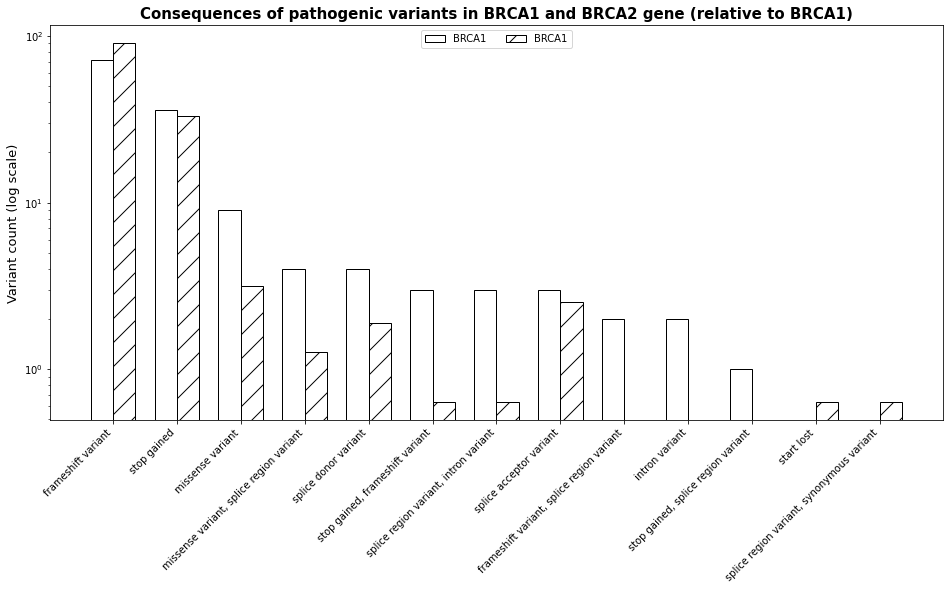

In [54]:
fig = plt.subplots(figsize=(16, 16))
# consequences of pathogenic variants in gene 1,2
ar4 = np.arange(len(cons_patall_df['index_1']))
wid4 = 0.35
ax4 = plt.subplot(2,1,1)
ax4.set_xticks(ar4)
ax4.set_xticklabels(cons_patall_df['index_1'], rotation = 45, ha = 'right')

ax4.set_title(('Consequences of pathogenic variants in ' + gene_name1.upper() + ' and ' + 
               gene_name2.upper() + ' gene (relative to ' + gene_name1.upper() + ')'), 
              fontsize = 15, fontweight = 'bold')

ax4.bar(ar4-wid4/2, cons_patall_df['Consequence_VEP_1'], width = wid4, color = 'white', 
        edgecolor = 'black', label = gene_name1.upper())
ax4.bar(ar4+wid4/2, cons_patall_df['Consequence_VEP_2_rel'], width = wid4, color = 'white', hatch = '/',
        edgecolor = 'black', label = gene_name1.upper())
ax4.set_ylabel('Variant count (log scale)', fontsize = 13)
ax4.set_yscale('log')
plt.legend(ncol = 2, loc = 'upper center');

## Location of as pathogenic characterized variants

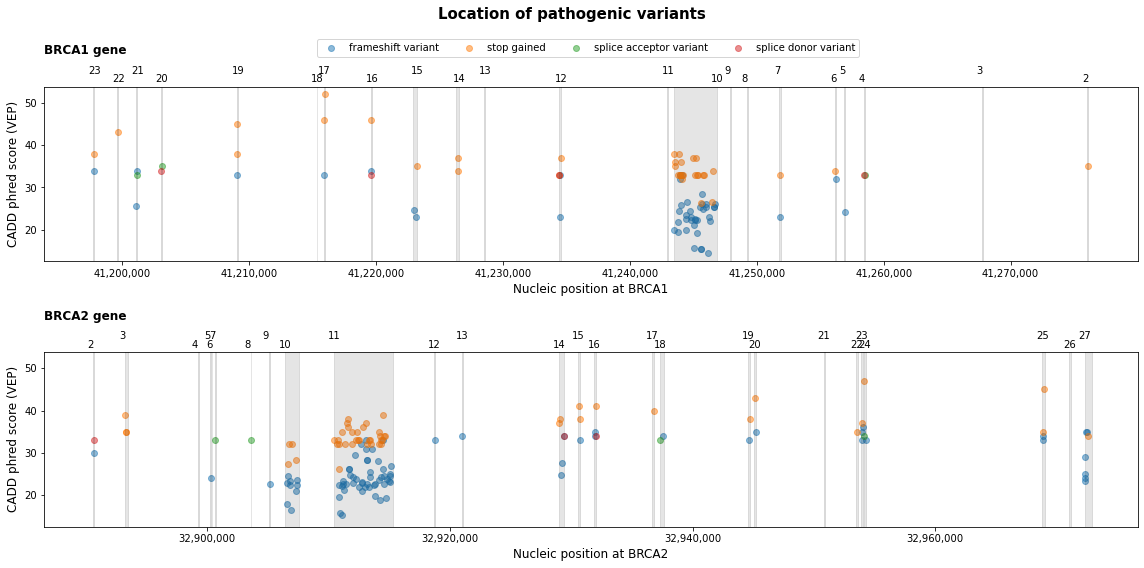

In [56]:
fig = plt.subplots(figsize=(16, 8))
if gene_name2 != '':
    ax1 = plt.subplot(2,1,1)
else:
    ax1 = plt.subplot(1,1,1)
# location of pathogenic variants with frameshift/stop gained gene 1
plt.suptitle('Location of pathogenic variants', fontsize=15, fontweight = 'bold')
ax1.set_title(gene_name1.upper() + ' gene', fontsize=12, 
              fontweight = 'bold', y=1.15, loc = 'left')
ax1.scatter(x = df1['POS'][(df1['ClinVar_gnomAD'] == 'Pathogenic') &
                           (df1['Consequence_VEP'] == 'frameshift variant')], 
            y = df1['CADD_PHRED_VEP'][(df1['ClinVar_gnomAD'] == 'Pathogenic') &
                                       (df1['Consequence_VEP'] == 'frameshift variant')], 
            alpha = 0.5, label = 'frameshift variant')
ax1.scatter(x = df1['POS'][(df1['ClinVar_gnomAD'] == 'Pathogenic') &
                           (df1['Consequence_VEP'] == 'stop gained')], 
            y = df1['CADD_PHRED_VEP'][(df1['ClinVar_gnomAD'] == 'Pathogenic') &
                                      (df1['Consequence_VEP'] == 'stop gained')], 
            alpha = 0.5, label = 'stop gained')
ax1.scatter(x = df1['POS'][(df1['ClinVar_gnomAD'] == 'Pathogenic') &
                           (df1['Consequence_VEP'] == 'splice acceptor variant')], 
            y = df1['CADD_PHRED_VEP'][(df1['ClinVar_gnomAD'] == 'Pathogenic') &
                                      (df1['Consequence_VEP'] == 'splice acceptor variant')], 
            alpha = 0.5, label = 'splice acceptor variant')
ax1.scatter(x = df1['POS'][(df1['ClinVar_gnomAD'] == 'Pathogenic') &
                           (df1['Consequence_VEP'] == 'splice donor variant')], 
            y = df1['CADD_PHRED_VEP'][(df1['ClinVar_gnomAD'] == 'Pathogenic') &
                                      (df1['Consequence_VEP'] == 'splice donor variant')], 
            alpha = 0.5, label = 'splice donor variant')
plt.legend(bbox_to_anchor = (0.75, 1.3), ncol = 5)

ax1.set_xlabel('Nucleic position at ' + gene_name1.upper(), fontsize = 12)
ax1.set_ylabel('CADD phred score (VEP)', fontsize = 12)
ax1.ticklabel_format(style = 'plain')
ax1.get_xaxis().set_major_formatter(tick.StrMethodFormatter('{x:,.0f}'))
#plt.legend(bbox_to_anchor = (1, 1.12), ncol = 2)

if gene_name2 != '':
    # consequences of pathogenic variants gene 2
    ax2 = plt.subplot(2,1,2, sharey = ax1)
    ax2.set_title(gene_name2.upper() + ' gene', fontsize=12, 
                  fontweight = 'bold', y=1.15, loc = 'left')
    ax2.scatter(x = df2['POS'][(df2['ClinVar_gnomAD'] == 'Pathogenic') &
                               (df2['Consequence_VEP'] == 'frameshift variant')], 
                y = df2['CADD_PHRED_VEP'][(df2['ClinVar_gnomAD'] == 'Pathogenic') &
                                           (df2['Consequence_VEP'] == 'frameshift variant')], 
                alpha = 0.5, label = 'frameshift variant')
    ax2.scatter(x = df2['POS'][(df2['ClinVar_gnomAD'] == 'Pathogenic') &
                               (df2['Consequence_VEP'] == 'stop gained')], 
                y = df2['CADD_PHRED_VEP'][(df2['ClinVar_gnomAD'] == 'Pathogenic') &
                                          (df2['Consequence_VEP'] == 'stop gained')], 
                alpha = 0.5, label = 'stop gained')
    ax2.scatter(x = df2['POS'][(df2['ClinVar_gnomAD'] == 'Pathogenic') &
                               (df2['Consequence_VEP'] == 'splice acceptor variant')], 
                y = df2['CADD_PHRED_VEP'][(df2['ClinVar_gnomAD'] == 'Pathogenic') &
                                          (df2['Consequence_VEP'] == 'splice acceptor variant')], 
                alpha = 0.5, label = 'splice acceptor variant')
    ax2.scatter(x = df2['POS'][(df2['ClinVar_gnomAD'] == 'Pathogenic') &
                               (df2['Consequence_VEP'] == 'splice donor variant')], 
                y = df2['CADD_PHRED_VEP'][(df2['ClinVar_gnomAD'] == 'Pathogenic') &
                                          (df2['Consequence_VEP'] == 'splice donor variant')], 
                alpha = 0.5, label = 'splice donor variant')
    ax2.set_xlabel('Nucleic position at ' + gene_name2.upper(), fontsize = 12)
    ax2.set_ylabel('CADD phred score (VEP)', fontsize = 12)
    ax2.ticklabel_format(style = 'plain')
    ax2.get_xaxis().set_major_formatter(tick.StrMethodFormatter('{x:,.0f}'))
    handles, labels = plt.gca().get_legend_handles_labels()
    patch = pplt.Patch(color='grey', label='Exons')
    handles.extend([patch])
    (y_min1, y_max1) = plt.ylim()
    if df1.iloc[0]['Strand'] == '+':
        for tup,l in zip(tuple_exons1, range(len(tuple_exons1))):
            ax1.add_patch(pplt.Rectangle((int(tup[0]), -.3), abs(int(tup[0])-int(tup[1])), 55, 
                                         fc = 'black', ec = 'black', alpha = 0.1))
            if (l+2)%2 == 0:
                ax1.text(int(tup[0])-500, y_max1+1, str((int(l)+2)), size = 10)
            else:
                ax1.text(int(tup[0])-500, y_max1+3, str((int(l)+2)), size = 10)
    elif df1.iloc[0]['Strand'] == '-':
        for tup,l in zip(tuple_exons1, range(len(tuple_exons1))):
            ax1.add_patch(pplt.Rectangle((int(tup[1]), -.3), abs(int(tup[0])-int(tup[1])), 55, 
                                         fc = 'black', ec = 'black', alpha = 0.1))
            if (l+2)%2 == 0:
                ax1.text(int(tup[0])-500, y_max1+1, str((int(l)+2)), size = 10)
            else:
                ax1.text(int(tup[0])-500, y_max1+3, str((int(l)+2)), size = 10)
    if df2.iloc[0]['Strand'] == '+':
        for tup,l in zip(tuple_exons2, range(len(tuple_exons2))):
            ax2.add_patch(pplt.Rectangle((int(tup[0]), -.3), abs(int(tup[0])-int(tup[1])), 55, fc = 'black', 
                                         ec = 'black', alpha = 0.1))
            if (l+2)%2 == 0:
                ax2.text(int(tup[0])-500, y_max1+1, str((int(l)+2)), size = 10)
            else:
                ax2.text(int(tup[0])-500, y_max1+3, str((int(l)+2)), size = 10)
    elif df2.iloc[0]['Strand'] == '-':
        for tup,l in zip(tuple_exons2, range(len(tuple_exons2))):
            ax2.add_patch(pplt.Rectangle((int(tup[1]), -.3), abs(int(tup[0])-int(tup[1])), 55, fc = 'black', 
                                         ec = 'black', alpha = 0.1))
            if (l+2)%2 == 0:
                ax2.text(int(tup[0])-500, y_max1+1, str((int(l)+2)), size = 10)
            else:
                ax2.text(int(tup[0])-500, y_max1+3, str((int(l)+2)), size = 10)
    plt.tight_layout();
    plt.savefig(r'figures/' + date + '_' + gene_name1.lower() + '_' + gene_name2.lower() + '_loc_pat.pdf')
    plt.savefig(r'figures/' + date + '_' + gene_name1.lower() + '_' + gene_name2.lower() + '_loc_pat.jpg')
else:
    plt.tight_layout()
    plt.savefig(r'figures/' + date + '_' + gene_name1.lower() + '_loc_pat.pdf')
    plt.savefig(r'figures/' + date + '_' + gene_name1.lower() + '_loc_pat.jpg')

# Deleteriousness of variants

## GnomAD Allele Frequency vs. CADD phred score

In [60]:
df1_af_cadd1 = df1[(df1['AF_gnomAD'].notnull())&(df1['CADD_PHRED_VEP'].notnull())].copy()
df1_af_cadd1['AF_to_CADD'] = df1_af_cadd1['AF_gnomAD']/df1_af_cadd1['CADD_PHRED_VEP']
p1_l = np.percentile(df1_af_cadd1['AF_to_CADD'], 10)
p1_h = np.percentile(df1_af_cadd1['AF_to_CADD'], 90)
if gene_name2 != '':
    df2_af_cadd2 = df2[(df2['AF_gnomAD'].notnull())&(df2['CADD_PHRED_VEP'].notnull())].copy()
    df2_af_cadd2['AF_to_CADD'] = df2_af_cadd2['AF_gnomAD']/df2_af_cadd2['CADD_PHRED_VEP']
    p2_l = np.percentile(df1_af_cadd1['AF_to_CADD'], 5)
    p2_h = np.percentile(df2_af_cadd2['AF_to_CADD'], 95)

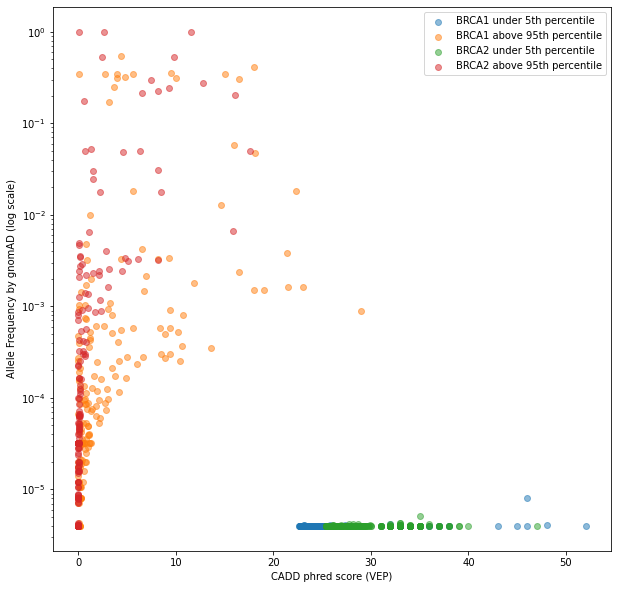

In [63]:
fig = plt.figure(figsize = (10,10))
for df, g, pl, ph in zip([df1_af_cadd1, df2_af_cadd2], gene_names, [p1_l, p2_l], [p1_h, p2_h]):
    plt.scatter(x = df['CADD_PHRED_VEP'][(df['AF_to_CADD']<pl)], 
                y = df['AF_gnomAD'][(df['AF_to_CADD']<pl)], 
                label = g.upper() + ' under 5th percentile', alpha = 0.5)
    plt.scatter(x = df['CADD_PHRED_VEP'][(df['AF_to_CADD']>ph)], 
                y = df['AF_gnomAD'][(df['AF_to_CADD']>ph)], 
                label = g.upper() + ' above 95th percentile', alpha = 0.5)
plt.yscale('log')
#plt.xscale('log')
plt.ylabel('Allele Frequency by gnomAD (log scale)')
plt.xlabel('CADD phred score (VEP)')
plt.legend();

In [58]:
df_inall = []
df_clin_nct_cbp = []
df_nct_cbp = []
for df in dfs:
    df_inall.append(df[df['ClinVar_gnomAD'].notnull() & 
                   df['NCT_SAMPLE_NAME'].notnull() & 
                   df['Annotation_cBP'].notnull() & 
                   df['Trans_Version_Flossies'].notnull()]) #1:21, 2:17
    df_clin_nct_cbp.append(df[df['ClinVar_gnomAD'].notnull() & 
                   df['NCT_SAMPLE_NAME'].notnull() & 
                   df['Annotation_cBP'].notnull()]) #1:31, 2:30
    df_nct_cbp.append(df[df['NCT_SAMPLE_NAME'].notnull() & 
                  df['Annotation_cBP'].notnull()]) #1:38, 2:35


In [64]:
# dfs sorted by clinvar_order
afc1 = df1[df1['ClinVar_gnomAD'].notnull()].copy()
afc1['ClinVar_gnomAD'] = afc1['ClinVar_gnomAD'].astype(clinvar_order)
afc1 = afc1.sort_values('ClinVar_gnomAD')

if gene_name2 != '':
    afc2 = df2[df2['ClinVar_gnomAD'].notnull()].copy()
    afc2['ClinVar_gnomAD'] = afc2['ClinVar_gnomAD'].astype(clinvar_order)
    afc2 = afc2.sort_values('ClinVar_gnomAD')

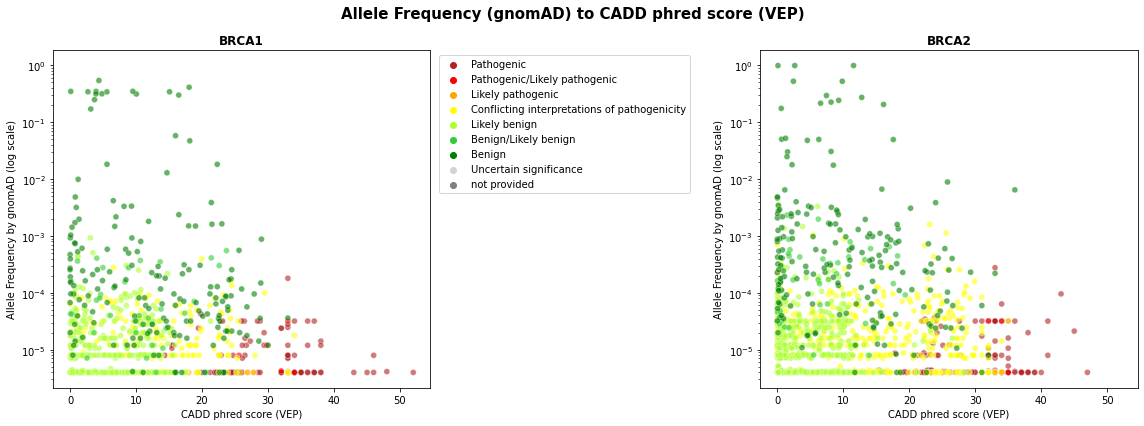

In [151]:
# allele frequency (gnomAD) and cadd score of variants

fig = plt.subplots(figsize = (16,6))
plt.suptitle('Allele Frequency (gnomAD) to CADD phred score (VEP)', fontsize = 15, fontweight = 'bold')
ax1 = plt.subplot(1,2,1)
ax1.set_title(label = gene_name1.upper(), fontsize = 12, fontweight = 'bold')
sns.scatterplot(ax = ax1, data = afc1[(afc1['ClinVar_gnomAD'] != 'Uncertain significance')&
                                      (afc1['ClinVar_gnomAD'] != 'not provided')], 
                x = 'CADD_PHRED_VEP', y = 'AF_gnomAD', hue = 'ClinVar_gnomAD', 
                palette = ['firebrick', 'red', 'orange', 'yellow', 'greenyellow', 'limegreen', 'green', 
                           'lightgray', 'grey'], alpha = 0.6)
ax1.set_yscale('log')
ax1.set_ylabel('Allele Frequency by gnomAD (log scale)')
ax1.set_xlabel('CADD phred score (VEP)')
ax1.legend(bbox_to_anchor = (1.7, 1))
plt.tight_layout();

ax2 = plt.subplot(1,2,2, sharex = ax1, sharey = ax1)
ax2.set_title(label = gene_name2.upper(), fontsize = 12, fontweight = 'bold')
sns.scatterplot(ax = ax2, data = afc2[(afc2['ClinVar_gnomAD'] != 'Uncertain significance')&
                                      (afc2['ClinVar_gnomAD'] != 'not provided')], 
                x = 'CADD_PHRED_VEP', y = 'AF_gnomAD', hue = 'ClinVar_gnomAD', 
                palette = ['firebrick', 'red', 'orange', 'yellow', 'greenyellow', 'limegreen', 'green', 
                           'lightgray', 'grey'], alpha = 0.6, legend = False)
ax2.set_yscale('log')
ax2.set_ylabel('Allele Frequency by gnomAD (log scale)')
ax2.set_xlabel('CADD phred score (VEP)')
plt.tight_layout()

if len(gene_names) > 1:
    plt.savefig(r'figures/' + date + '_' + gene_names[0] + '_' + gene_names[1] + '_cadd_af.pdf')
    plt.savefig(r'figures/' + date + '_' + gene_names[0] + '_' + gene_names[1] + '_cadd_af.jpg')
else:
    plt.savefig(r'figures/' + date + '_' + gene_names[0] + '_cadd_af.pdf')
    plt.savefig(r'figures/' + date + '_' + gene_names[0] + '_cadd_af.jpg')

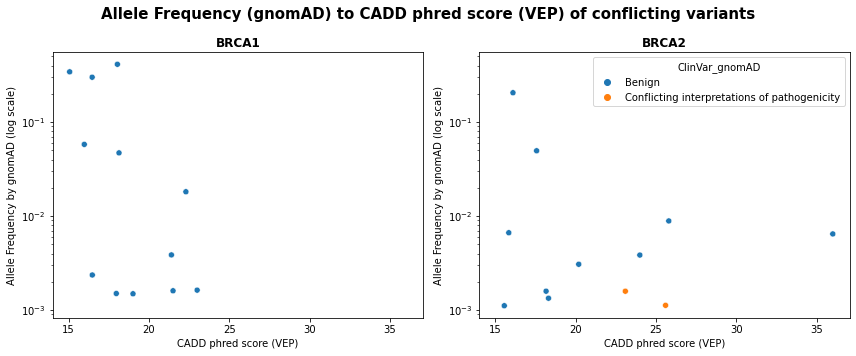

In [137]:
# allele frequency and cadd score of some variants (CADD > 15, AF > 0.001)
fig = plt.subplots(figsize = (12,5))
plt.suptitle('Allele Frequency (gnomAD) to CADD phred score (VEP) of conflicting variants', 
             fontsize = 15, fontweight = 'bold')
ax1 = plt.subplot(1,2,1)
ax1.set_title(gene_name1.upper(), fontweight = 'bold')
sns.scatterplot(ax = ax1, data = df1[(df1['CADD_PHRED_VEP'] > 15)&(df1['AF_gnomAD'] > 0.001)], 
                x = 'CADD_PHRED_VEP', y = 'AF_gnomAD', hue = 'ClinVar_gnomAD', legend = False)
ax1.set_yscale('log')
ax1.set_ylabel('Allele Frequency by gnomAD (log scale)')
ax1.set_xlabel('CADD phred score (VEP)')
plt.tight_layout()

ax2 = plt.subplot(1,2,2, sharex = ax1, sharey = ax1)
ax2.set_title(gene_name2.upper(), fontweight = 'bold')
sns.scatterplot(ax = ax2, data = df2[(df2['CADD_PHRED_VEP'] > 15)&(df2['AF_gnomAD'] > 0.001)], 
                x = 'CADD_PHRED_VEP', y = 'AF_gnomAD', hue = 'ClinVar_gnomAD')
ax2.set_yscale('log')
ax2.set_ylabel('Allele Frequency by gnomAD (log scale)')
ax2.set_xlabel('CADD phred score (VEP)')
#ax2.legend(bbox_to_anchor = (-0.1, 1))
plt.tight_layout();

if len(gene_names) > 1:
    plt.savefig(r'figures/' + date + '_' + gene_names[0] + '_' + gene_names[1] + '_cadd_af_confl.pdf')
    plt.savefig(r'figures/' + date + '_' + gene_names[0] + '_' + gene_names[1] + '_cadd_af_confl.jpg')
else:
    plt.savefig(r'figures/' + date + '_' + gene_names[0] + '_cadd_af_confl.pdf')
    plt.savefig(r'figures/' + date + '_' + gene_names[0] + '_cadd_af_confl.jpg')

In [183]:
df1[#(df1['Overall_Frequency_Flossies'].notnull())&
    (df1['ClinVar_gnomAD'].notnull())&
    (df1['AF_gnomAD'] > 0.001)&
    (df1['CADD_PHRED_VEP'] > 20)]

,Identifier,CHROM,POS,REF,ALT,Ref_Trans_VEP,Consequence_VEP,Impact_VEP,EXON,INTRON,...,KGE_RefSeq,NCT_TumorVariantFrequency,NCT_ZYGOSITY,Trans_Version_Findlay,Consequence_Findlay,Function_Findlay,SIFT_VEP_str,SIFT_VEP_num,PolyPhen_VEP_str,PolyPhen_VEP_num
5774,17:g.41222975C>T,17,41222975,C,T,NM_007294,missense variant,MODERATE,15/23,NaN,...,NM_007294.3,0.44,het,3.0,Missense,FUNC,tolerated,0.40,benign,0.003
10804,17:g.41243509T>C,17,41243509,T,C,NM_007294,missense variant,MODERATE,10/23,NaN,...,NM_007294.3,0.44,het,NaN,NaN,NaN,tolerated,0.09,benign,0.071
15285,17:g.41244982A>G,17,41244982,A,G,NM_007294,missense variant,MODERATE,10/23,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,deleterious,0.02,possibly_damaging,0.733
15419,17:g.41245027G>A,17,41245027,G,A,NM_007294,missense variant,MODERATE,10/23,NaN,...,NM_007294.3,0.49,het,NaN,NaN,NaN,deleterious,0.00,benign,0.006


In [173]:
df2.columns

Index(['Identifier', 'CHROM', 'POS', 'REF', 'ALT', 'Ref_Trans_VEP',
       'Consequence_VEP', 'Impact_VEP', 'EXON', 'INTRON', 'Protein_position',
       'Amino_acids', 'Codons', 'SIFT_VEP', 'PolyPhen_VEP', 'CADD_PHRED_VEP',
       'CADD_RAW_VEP', 'Ada_score_VEP', 'Ref_Genome', 'Strand',
       'Ref_Transcript', 'Trans_Version_Syn', 'Trans_Version_Flossies',
       'Consequence_Flossies', 'Splice_Change_Flossies',
       'European_(n=7325)_Flossies', 'African_(n=2559)_Flossies',
       'Overall_Frequency_Flossies', 'Cancer_Type_cBP', 'Protein_Change_cBP',
       'Annotation_cBP', 'Functional_Impact_cBP', 'MS_cBP', 'ClinVar_gnomAD',
       'AC_gnomAD', 'AN_gnomAD', 'AF_gnomAD', 'HOM_gnomAD', 'NCT_SAMPLE_NAME',
       'NCT_Sheet', 'KGE_RefSeq', 'NCT_TumorVariantFrequency', 'NCT_ZYGOSITY',
       'Variant_Rich', 'HDR_Rich', '95%_CI_lower_bound_Rich',
       '95%_CI_upper_bound_Rich', 'Prev_HDR_Rich', 'SIFT_VEP_str',
       'SIFT_VEP_num', 'PolyPhen_VEP_str', 'PolyPhen_VEP_num'],
      dtyp

In [186]:
df1[['Identifier', 'EXON', 'Consequence_VEP', 'AF_gnomAD', 'ClinVar_gnomAD', 'CADD_PHRED_VEP', 
     'Overall_Frequency_Flossies', 'Amino_acids', 'SIFT_VEP_num', 
     'PolyPhen_VEP_num']][#(df2['Overall_Frequency_Flossies'].notnull())&
                                    (df1['CADD_PHRED_VEP']>20)&
                                    (df1['AF_gnomAD'] > 0.001)]
#df2[df2['Identifier'] == '13:g.32945172A>C']

,Identifier,EXON,Consequence_VEP,AF_gnomAD,ClinVar_gnomAD,CADD_PHRED_VEP,Overall_Frequency_Flossies,Amino_acids,SIFT_VEP_num,PolyPhen_VEP_num
5774,17:g.41222975C>T,15/23,missense variant,0.018181,Benign,22.3,0.02310,M/I,0.40,0.003
10804,17:g.41243509T>C,10/23,missense variant,0.003869,Benign,21.4,0.01000,R/G,0.09,0.071
15285,17:g.41244982A>G,10/23,missense variant,0.001632,Benign,23.0,NaN,Y/H,0.02,0.733
15419,17:g.41245027G>A,10/23,missense variant,0.001607,Benign,21.5,0.00374,R/W,0.00,0.006


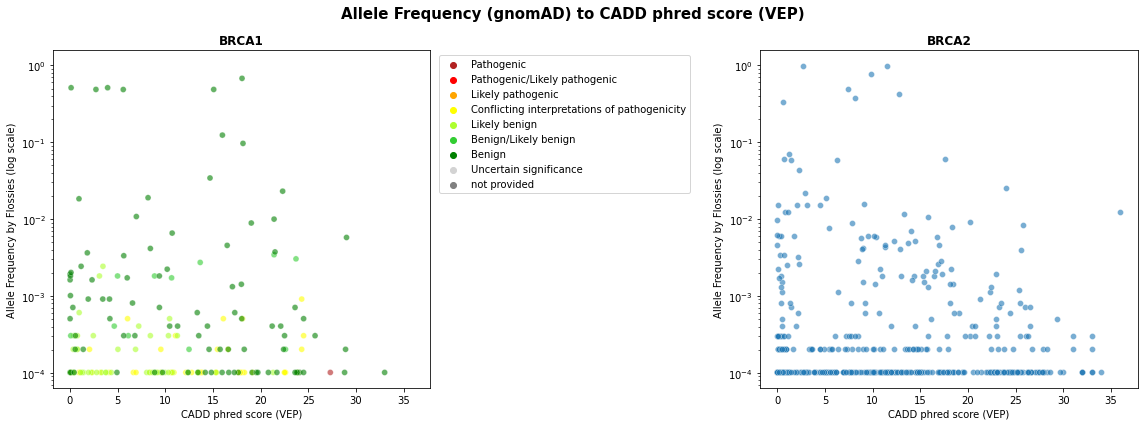

In [152]:
# allele frequency of Flossies and cadd score of variants

fig = plt.subplots(figsize = (16,6))
plt.suptitle('Allele Frequency (gnomAD) to CADD phred score (VEP)', fontsize = 15, fontweight = 'bold')
ax1 = plt.subplot(1,2,1)
ax1.set_title(label = gene_name1.upper(), fontsize = 12, fontweight = 'bold')
sns.scatterplot(ax = ax1, data = afc1[(afc1['ClinVar_gnomAD'] != 'Uncertain significance')&
                                      (afc1['ClinVar_gnomAD'] != 'not provided')], 
                x = 'CADD_PHRED_VEP', y = 'Overall_Frequency_Flossies', hue = 'ClinVar_gnomAD', 
                palette = ['firebrick', 'red', 'orange', 'yellow', 'greenyellow', 'limegreen', 'green', 
                           'lightgray', 'grey'], alpha = 0.6)
ax1.set_yscale('log')
ax1.set_ylabel('Allele Frequency by Flossies (log scale)')
ax1.set_xlabel('CADD phred score (VEP)')
ax1.legend(bbox_to_anchor = (1.7, 1))
plt.tight_layout();

ax2 = plt.subplot(1,2,2, sharex = ax1, sharey = ax1)
ax2.set_title(label = gene_name2.upper(), fontsize = 12, fontweight = 'bold')
sns.scatterplot(ax = ax2, data = df2,#[(df2['ClinVar_gnomAD'] != 'Uncertain significance')&
                                      #(df2['ClinVar_gnomAD'] != 'not provided')], 
                x = 'CADD_PHRED_VEP', y = 'Overall_Frequency_Flossies', #hue = 'ClinVar_gnomAD', 
                palette = ['firebrick', 'red', 'orange', 'yellow', 'greenyellow', 'limegreen', 'green', 
                           'lightgray', 'grey'], alpha = 0.6, legend = False)
ax2.set_yscale('log')
ax2.set_ylabel('Allele Frequency by Flossies (log scale)')
ax2.set_xlabel('CADD phred score (VEP)')
plt.tight_layout()

if len(gene_names) > 1:
    plt.savefig(r'figures/' + date + '_' + gene_names[0] + '_' + gene_names[1] + '_cadd_flos.pdf')
    plt.savefig(r'figures/' + date + '_' + gene_names[0] + '_' + gene_names[1] + '_cadd_flos.jpg')
else:
    plt.savefig(r'figures/' + date + '_' + gene_names[0] + '_cadd_flos.pdf')
    plt.savefig(r'figures/' + date + '_' + gene_names[0] + '_cadd_flos.jpg')

In [101]:
df2[(df2['CADD_PHRED_VEP'] > 15)&(df2['AF_gnomAD'] > 0.001)&(df2['ClinVar_gnomAD'] == 'Conflicting interpretations of pathogenicity')]

,Identifier,CHROM,POS,REF,ALT,Ref_Trans_VEP,Consequence_VEP,Impact_VEP,EXON,INTRON,...,NCT_ZYGOSITY,Variant_Rich,HDR_Rich,95%_CI_lower_bound_Rich,95%_CI_upper_bound_Rich,Prev_HDR_Rich,SIFT_VEP_str,SIFT_VEP_num,PolyPhen_VEP_str,PolyPhen_VEP_num
24885,13:g.32915313G>T,13,32915313,G,T,NM_000059,missense variant,MODERATE,11/27,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,tolerated,0.37,possibly_damaging,0.804
34256,13:g.32945172A>C,13,32945172,A,C,NM_000059,missense variant,MODERATE,20/27,NaN,...,NaN,p.Glu2856Ala,3.999045,3.533873,4.520244,Previously Published,deleterious,0.03,possibly_damaging,0.798


In [108]:
df1['Overall_Frequency_Flossies'][(df1['Overall_Frequency_Flossies']>0.001)&
                                  (df1['CADD_PHRED_VEP']>15)]

636      0.00890
5774     0.02310
6576     0.00132
6602     0.00344
7494     0.00455
10804    0.01000
13625    0.48700
15146    0.67900
15419    0.00374
16770    0.12400
19623    0.00304
19838    0.09670
22189    0.00142
22293    0.00577
Name: Overall_Frequency_Flossies, dtype: float64

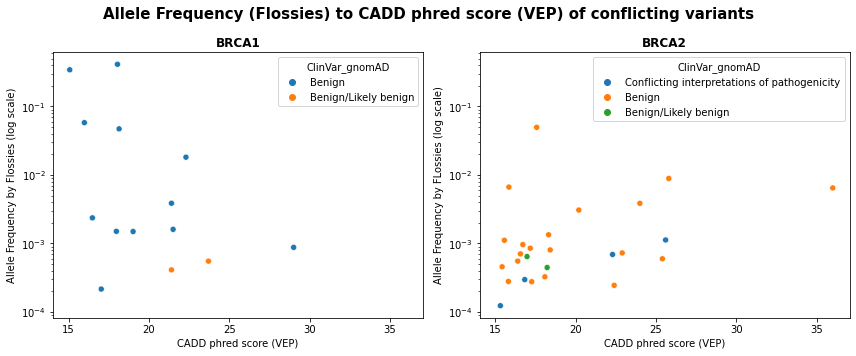

In [147]:
# allele frequency and cadd score of some variants (CADD > 15, AF > 0.001)
fig = plt.subplots(figsize = (12,5))
plt.suptitle('Allele Frequency (Flossies) to CADD phred score (VEP) of conflicting variants', 
             fontsize = 15, fontweight = 'bold')
ax1 = plt.subplot(1,2,1)
ax1.set_title(gene_name1.upper(), fontweight = 'bold')
sns.scatterplot(ax = ax1, data = df1[(df1['CADD_PHRED_VEP'] > 15)&(df1['Overall_Frequency_Flossies'] > 0.001)],
                x = 'CADD_PHRED_VEP', y = 'AF_gnomAD', hue = 'ClinVar_gnomAD')
ax1.set_yscale('log')
ax1.set_ylabel('Allele Frequency by Flossies (log scale)')
ax1.set_xlabel('CADD phred score (VEP)')
plt.tight_layout()

ax2 = plt.subplot(1,2,2, sharex = ax1, sharey = ax1)
ax2.set_title(gene_name2.upper(), fontweight = 'bold')
sns.scatterplot(ax = ax2, data = df2[(df2['CADD_PHRED_VEP'] > 15)&(df2['Overall_Frequency_Flossies'] > 0.001)],
                x = 'CADD_PHRED_VEP', y = 'AF_gnomAD', hue = 'ClinVar_gnomAD')
ax2.set_yscale('log')
ax2.set_ylabel('Allele Frequency by FLossies (log scale)')
ax2.set_xlabel('CADD phred score (VEP)')
#ax2.legend(bbox_to_anchor = (-0.1, 0.8))
plt.tight_layout()

;
if len(gene_names) > 1:
    plt.savefig(r'figures/' + date + '_' + gene_names[0] + '_' + gene_names[1] + '_cadd_floss_confl.pdf')
    plt.savefig(r'figures/' + date + '_' + gene_names[0] + '_' + gene_names[1] + '_cadd_floss_confl.jpg')
else:
    plt.savefig(r'figures/' + date + '_' + gene_names[0] + '_cadd_floss_confl.pdf')
    plt.savefig(r'figures/' + date + '_' + gene_names[0] + '_cadd_floss_confl.jpg')

## Division in groups for prediction of deleteriousness

In [139]:
'''
divide variants into groups of deleteriousness

set thresholds for deleteriosness of variants
- whole df: 42623 variants
- AF_gnomAD < 0.001 (allele frequency, 3600 variants of 3670)
- CADD_PHRED_VEP > 15 (rank of variant to substitution in whole human reference genome, 15571 variants of 42348)
- Ada_score_VEP > 0.6 (splicing effect score, 710 variants of 1884)
- SIFT_VEP_num < 0.05 (resulting changed protein function by aa change, 10553 of 22772)
- PolyPhen_VEP_num > 0.6 (resulting changed protein structure/function by aa change, 6073 of 22772)
- Impact_VEP == 'HIGH'
- ClinVar_gnomAD == 'Pathogenic', 'Pathogenic/Likely pathogenic', 'Conflicting interpretations of pathogenicity', 'not provided', 'Uncertain significance'

results:
- for everything: no result
- if no Ada_score (for splice effects) --> one result: start_lost (of 9x 'start lost')
- if add. no Impact_VEP --> 366 results for 'cplt_path_group'


'''

# variants completely categorized as deleterious
cplt_path_group = []
cplt_ben_group = []
for df in dfs:
    cplt_path_group.append(df[(df['AF_gnomAD'] < 0.001) &
                              (df['SIFT_VEP_num'] < 0.05) &
                              (df['CADD_PHRED_VEP'] > 15) &
                              (df['PolyPhen_VEP_num'] > 0.6) &
                              (df['ClinVar_gnomAD'].isin(['Pathogenic', 'Pathogenic/Likely pathogenic', 
                                                          'Conflicting interpretations of pathogenicity', 
                                                          'not provided', 'Uncertain significance']))])
    cplt_ben_group.append(df[(df['AF_gnomAD'] >= 0.001) &
                             (df['SIFT_VEP_num'] >= 0.05) &
                             (df['CADD_PHRED_VEP'] <= 15) &
                             (df['PolyPhen_VEP_num'] <= 0.6)])

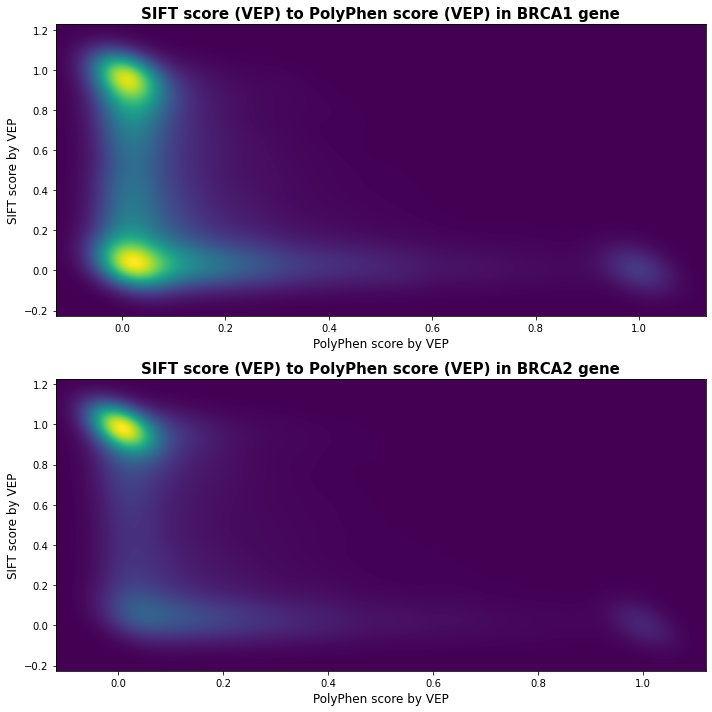

In [140]:
# SIFT_VEP vs. PolyPhen_VEP
fig = plt.subplots(figsize = (10,10))

#for df, g in zip(dfs, gene_names):
ax1 = plt.subplot(2,1,1)
ax1.set_title('SIFT score (VEP) to PolyPhen score (VEP) in ' + gene_name1.upper() + ' gene', 
              fontsize = 15, fontweight = 'bold')
ax1 = sns.kdeplot(data = df1, x = 'SIFT_VEP_num', y = 'PolyPhen_VEP_num', fill = True, thresh = 0, 
                  levels = 1000, cmap = 'viridis')
ax1.set_ylabel('SIFT score by VEP', fontsize = 12)
ax1.set_xlabel('PolyPhen score by VEP', fontsize = 12)
#plt.legend()

ax2 = plt.subplot(2,1,2)
ax2.set_title('SIFT score (VEP) to PolyPhen score (VEP) in ' + gene_name2.upper() + ' gene', 
              fontsize = 15, fontweight = 'bold')
ax2 = sns.kdeplot(data = df2, x = 'SIFT_VEP_num', y = 'PolyPhen_VEP_num', fill = True, thresh = 0, 
                  levels = 1000, cmap = 'viridis')
ax2.set_ylabel('SIFT score by VEP', fontsize = 12)
ax2.set_xlabel('PolyPhen score by VEP', fontsize = 12)
plt.tight_layout()

if len(gene_names) > 1:
    plt.savefig(r'figures/' + date + '_' + gene_names[0] + '_' + gene_names[1] + '_sift_pp_dens.pdf')
    plt.savefig(r'figures/' + date + '_' + gene_names[0] + '_' + gene_names[1] + '_sift_pp_dens.jpg')
else:
    plt.savefig(r'figures/' + date + '_' + gene_names[0] + '_sift_pp_dens.pdf')
    plt.savefig(r'figures/' + date + '_' + gene_names[0] + '_sift_pp_dens.jpg')

In [143]:
(len(df1[(df1['SIFT_VEP_num']>0.05) & (df1['PolyPhen_VEP_num']>0.6)]), 
len(df2[(df2['SIFT_VEP_num']>0.05) & (df2['PolyPhen_VEP_num']>0.6)]))

(939, 3022)

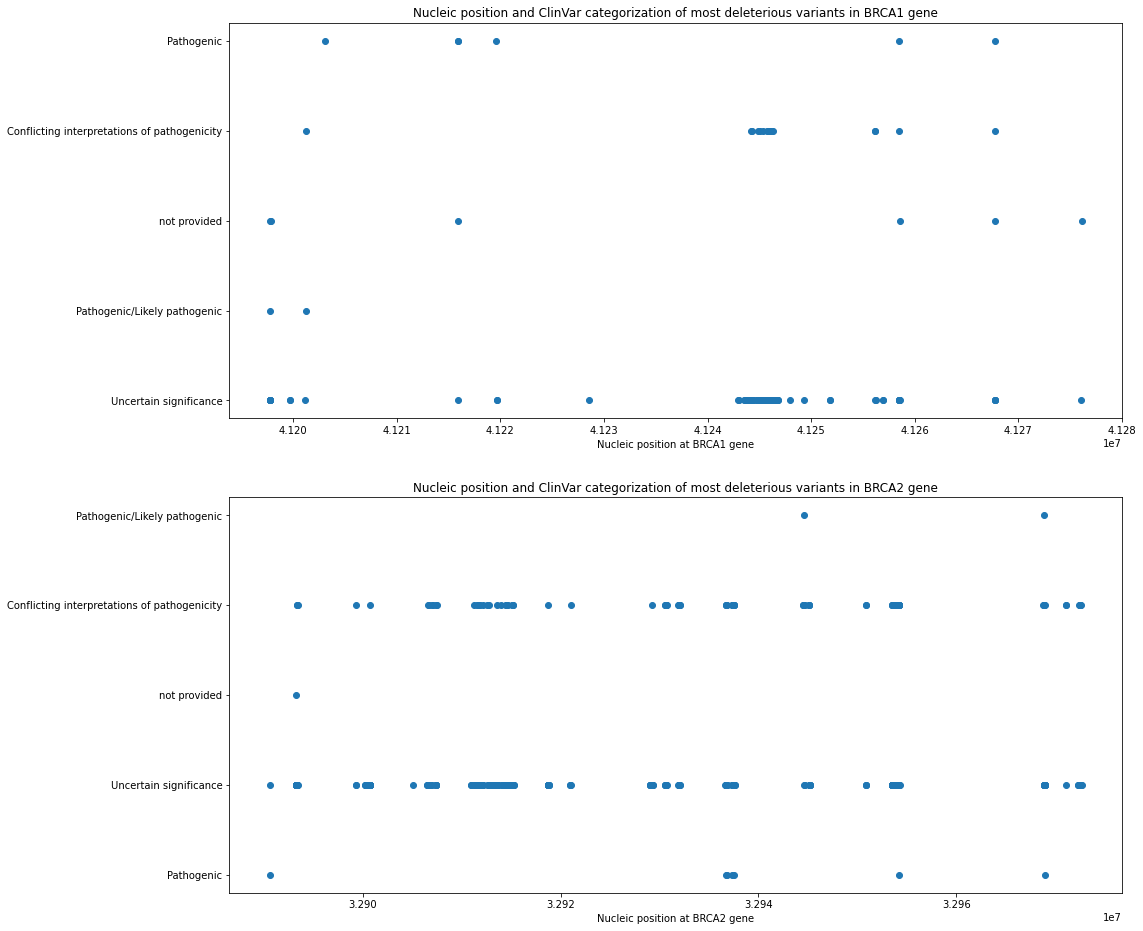

In [30]:
# nucleic positions of variants in cplt pathogen group + ClinVar annotation

fig = plt.subplots(figsize=(16, 16))

if gene_name2 != '':
    ax1 = plt.subplot(2,1,1)
    ax2 = plt.subplot(2,1,2)
    axes = [ax1, ax2]
else:
    ax1 = plt.subplot(1,1,1)
    axes = [ax1]
    
for p, g, a in zip(cplt_path_group, gene_names, axes):
    a.scatter(p['POS'], p['ClinVar_gnomAD'])
    a.set_title('Nucleic position and ClinVar categorization of most deleterious variants in ' + 
                g.upper() + ' gene')
    a.set_xlabel('Nucleic position at ' + g.upper() + ' gene')
#plt.xlabel('Nucleic position at ' + gene_name[0].upper() + ' and ' + gene_name[1].upper() + ' genes')
#plt.title('Nucleic position and ClinVar categorization of most deleterious variants in ' + gene_names[0].upper() + ' and ' + gene_names[0].upper() + ' gene');

## Stop gain

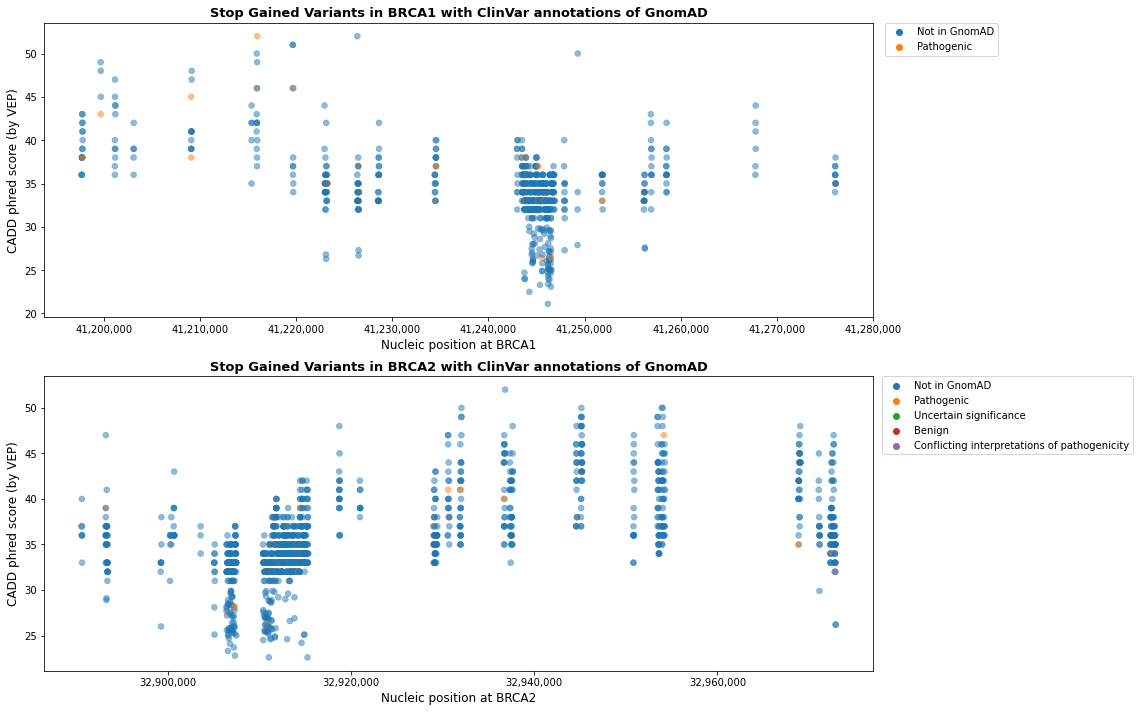

In [145]:
'''
Where are variants with gained stop codons?
Which variants are how annotated in ClinVar, which in cBioPortal?
'''

# for stop gain --> where are variants with gained stop codons, how annotated in ClinVar, which in cBioPortal
fig = plt.subplots(figsize = (16,10))
ax1 = plt.subplot(2,1,1)
sns.scatterplot(ax = ax1, x = df1['POS'][df1['Consequence_VEP'] == 'stop gained'], 
                y = df1['CADD_PHRED_VEP'][df1['Consequence_VEP'] == 'stop gained'], 
                hue = df1['ClinVar_gnomAD'][df1['Consequence_VEP'] == 'stop gained'].fillna('Not in GnomAD'), 
                edgecolor = None, alpha = 0.5)
ax1.set_title('Stop Gained Variants in ' + gene_name1.upper() + ' with ClinVar annotations of GnomAD', 
          fontsize=13, fontweight = 'bold')
ax1.set_xlabel('Nucleic position at ' + gene_name1.upper(), fontsize = 12)
ax1.set_ylabel('CADD phred score (by VEP)', fontsize = 12)
ax1.ticklabel_format(style = 'plain')
ax1.get_xaxis().set_major_formatter(tick.StrMethodFormatter('{x:,.0f}'))
ax1.legend(bbox_to_anchor = (1.15, 1), borderaxespad = 0);
plt.tight_layout

ax2 = plt.subplot(2,1,2)
sns.scatterplot(ax = ax2, x = df2['POS'][df2['Consequence_VEP'] == 'stop gained'], 
                y = df2['CADD_PHRED_VEP'][df2['Consequence_VEP'] == 'stop gained'], 
                hue = df2['ClinVar_gnomAD'][df2['Consequence_VEP'] == 'stop gained'].fillna('Not in GnomAD'), 
                edgecolor = None, alpha = 0.5)
ax2.set_title('Stop Gained Variants in ' + gene_name2.upper() + ' with ClinVar annotations of GnomAD', 
          fontsize=13, fontweight = 'bold')
ax2.set_xlabel('Nucleic position at ' + gene_name2.upper(), fontsize = 12)
ax2.set_ylabel('CADD phred score (by VEP)', fontsize = 12)
ax2.ticklabel_format(style = 'plain')
ax2.get_xaxis().set_major_formatter(tick.StrMethodFormatter('{x:,.0f}'))
ax2.legend(bbox_to_anchor = (1.01, 1), borderaxespad = 0)
plt.tight_layout
plt.gcf().subplots_adjust(bottom = 0.05, top = 0.95, left = 0.05, right = 0.77);
plt.savefig(r'figures/' + date + '_' + gene_name2.lower() + '_' + 
            gene_name1.lower() + '_stop_gains.pdf')
plt.savefig(r'figures/' + date + '_' + gene_name2.lower() + '_' + 
            gene_name1.lower() + '_stop_gains.jpeg')